# Exercise set 11

#### Exercise 1:

In [23]:
# import modules
%matplotlib inline
from numpy import *               # Matematiske funksjoner og lin.alg.
from numpy.linalg import norm, solve
from matplotlib.pyplot import *   # Grafikk
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
rcParams.update(newparams)

From [Wikipedia](https://en.wikipedia.org/wiki/Bogacki–Shampine_method) we have that the Bogacki-Shampine method is given by the formulas

\begin{align}
k_1 &= f(t_n, y_n) \\
k_2 &= f(t_n + \tfrac12 h_n, y_n + \tfrac12 h_n k_1) \\
k_3 &= f(t_n + \tfrac34 h_n, y_n + \tfrac34 h_n k_2) \\
y_{n+1} &= y_n + \tfrac29 h_n k_1 + \tfrac13 h_n k_2 + \tfrac49 h_n k_3 \\
k_4 &= f(t_n + h_n, y_{n+1}) \\
z_{n+1} &= y_n + \tfrac7{24} h_n k_1 + \tfrac14 h_n k_2 + \tfrac13 h_n k_3 + \tfrac18 h_n k_4,
\end{align}

where $y_{n+1}$ is a *third order* approximation to the solution, while $z_{n+1}$ is a *second order* approximation. The difference between these two will be used to approximate the error when constructing the adaptive method.

Using the Heun-Euler program as inspiration, we implement this as:

In [ ]:
def bogacki_shampine(f, x, y, h):
    # Do one step in the Bogacki–Shampine pair method
    k1 = f(x, y)
    k2 = f(x+h, y+(h/2)*k1)
    k3 = f(x+3*h/4, y+(3*h/4)*k2)
    y_neste= y+(h/9)*(2*k1+3*k2+4*k3) 
    
    # To compute the error estimate
    k4 = f(x+h,y_neste)
    z_neste = y + (h/24)*(7*k1+6*k2+8*k3+3*k4) 
    feil_estimat = norm(y_neste-z_neste)
    
    x_neste = x + h
    p = 2 # The order taken from wikipedia
    return x_neste, y_neste,feil_estimat, p

def heun_euler(f, x, y, h):
    # One step with the pair Heun/Euler
    # Input: the function f, the present state xn and yn  and the stepsize h
    # Output: the solution x and y in the next step, error estimate, and the
    #         order p of Eulers method (the lowest order) 
    
    k1 = f(x, y)
    k2 = f(x+h, y+h*k1)
    y_next = y + 0.5*h*(k1+k2)      # Heuns metode (lokal ekstrapolasjon)
    x_next = x + h
    error_estimate = 0.5*h*norm(k2-k1)   # The 2-norm or the error estimate
    p = 1
    return x_next, y_next, error_estimate, p

# adaptive solver from notebook on ODEs
def ode_adaptive(f, x0, xend, y0, h0, tol = 1.e-6, method=heun_euler):
    # Adaptive solver for ODEs
    #    y' = f(x,y), y(x0)=y0
    # 
    # Input: the function f, x0, xend, and the initial value y0
    #        intial stepsize h, the tolerance tol, 
    #         and a function (method) implementing one step of a pair.
    # Ut: Array med x- og y- verdier. 
    
    y_num = array([y0])    # Array for the solutions y
    x_num = array([x0])    # Array for the x-values

    xn = x0                # Running values for  x, y and the stepsize h
    yn = y0 
    h = h0
    Maxcall = 100000        # Maximum allowed calls of method
    ncall = 0
    
    # Main loop
    while xn < xend - 1.e-10:               # Buffer for truncation error
        # Adjust the stepsize for the last step
        if xn + h > xend:                   
            h = xend - xn 
        
        # Gjør et steg med valgt metode
        x_try, y_try, error_estimate, p = method(f, xn, yn, h)
        ncall = ncall + 1
        
        if error_estimate <= tol:   
            # Solution accepted, update x and y
            xn = x_try    
            yn = y_try
            # Store the solutions 
            y_num = concatenate((y_num, array([yn])))
            x_num = append(x_num, xn)
        
        # else: The step rejectes and nothing is updated. 
        
        # Adjust the stepsize
        h = 0.8*(tol/error_estimate)**(1/(p+1))*h
        
        # Stop with a warning in the case of max calls to method
        if ncall > Maxcall:
            print('Maximum number of method calls')
            return x_num, y_num

    # Some diagnostic output
    print('Number of accepted steps = ', len(x_num)-1)
    print('Number of rejected steps = ', ncall - len(x_num)+1)
    return x_num, y_num

In [ ]:
# define the right hand side
def f(x, y):
    return array([2*y[0] - y[0]*y[1],
                  0.5*y[0]*y[1] - y[1]])

y0 = array([2, 0.5]) # start values
x0 = 0; xend = 10; h0 = 100

# solve and plot solution
x_num, y_num = ode_adaptive(f, x0, xend, y0, h0, tol=1.e-3, method=bogacki_shampine)

plot(x_num, y_num, '.-')
title('Adaptive Bogacki-Shampine')
xlabel('x')
ylabel('y')
grid(True)
legend(['Numerical']);

In [ ]:
# Plot the step size sequence
h_n = diff(x_num)            # array with the stepsizes h_n = x_{n+1} 
x_n = x_num[0:-1]            # array with x_num[n], n=0..N-1
semilogy(x_n, h_n, '.-')
xlabel('x')
ylabel('h')
grid(True)
title('Stepsize variations');

In [ ]:
# Heun-Euler
# solve and plot solution
x_num, y_num = ode_adaptive(f, x0, xend, y0, h0, tol=1.e-3, method=heun_euler)

plot(x_num, y_num, '.-')
title('Heun-Euler')
xlabel('x')
ylabel('y')
grid(True)
legend(['Numerical']);

In [ ]:
# Plot the step size sequence
h_n = diff(x_num)            # array with the stepsizes h_n = x_{n+1} 
x_n = x_num[0:-1]            # array with x_num[n], n=0..N-1
semilogy(x_n, h_n, '.-')
xlabel('x')
ylabel('h')
grid(True)
title('Stepsize variations');

We clearly see that the Bogacki-Shampine method uses larger step sizes.

In [ ]:
# tol = 10^-05 and tol = 10^-07

# solve and plot solution
x_num, y_num = ode_adaptive(f, x0, xend, y0, h0, tol=1.e-5, method=bogacki_shampine)

plot(x_num, y_num, '.-')
title('Adaptive Bogacki-Shampine')
xlabel('x')
ylabel('y')
grid(True)
legend(['Numerical']);

In [ ]:
# Plot the step size sequence
h_n = diff(x_num)            # array with the stepsizes h_n = x_{n+1} 
x_n = x_num[0:-1]            # array with x_num[n], n=0..N-1
semilogy(x_n, h_n, '.-')
xlabel('x')
ylabel('h')
grid(True)
title('Stepsize variations');

In [ ]:
# tol = 10^-05 and tol = 10^-07

# solve and plot solution
x_num, y_num = ode_adaptive(f, x0, xend, y0, h0, tol=1.e-5, method=heun_euler)

plot(x_num, y_num, '.-')
title('Adaptive Heun-Euler')
xlabel('x')
ylabel('y')
grid(True)
legend(['Numerical']);

In [ ]:
# Plot the step size sequence
h_n = diff(x_num)            # array with the stepsizes h_n = x_{n+1} 
x_n = x_num[0:-1]            # array with x_num[n], n=0..N-1
semilogy(x_n, h_n, '.-')
xlabel('x')
ylabel('h')
grid(True)
title('Stepsize variations');

In [ ]:
# tol = 10^-05 and tol = 10^-07

# solve and plot solution
x_num, y_num = ode_adaptive(f, x0, xend, y0, h0, tol=1.e-7, method=bogacki_shampine)

plot(x_num, y_num, '.-')
title('Adaptive Bogacki-Shampine')
xlabel('x')
ylabel('y')
grid(True)
legend(['Numerical']);

In [ ]:
# Plot the step size sequence
h_n = diff(x_num)            # array with the stepsizes h_n = x_{n+1} 
x_n = x_num[0:-1]            # array with x_num[n], n=0..N-1
semilogy(x_n, h_n, '.-')
xlabel('x')
ylabel('h')
grid(True)
title('Stepsize variations');

In [ ]:
# tol = 10^-05 and tol = 10^-07

# solve and plot solution
x_num, y_num = ode_adaptive(f, x0, xend, y0, h0, tol=1.e-7, method=heun_euler)

plot(x_num, y_num, '.-')
title('Adaptive Heun-Euler')
xlabel('x')
ylabel('y')
grid(True)
legend(['Numerical']);

In [ ]:
# Plot the step size sequence
h_n = diff(x_num)            # array with the stepsizes h_n = x_{n+1} 
x_n = x_num[0:-1]            # array with x_num[n], n=0..N-1
semilogy(x_n, h_n, '.-')
xlabel('x')
ylabel('h')
grid(True)
title('Stepsize variations');

The number of steps used in each experiment is

|        Method    | $10^{-3}$ | $10^{-5}$ | $10^{-7}$ |        
|------------------|-----------|-----------|-----------|
| Bogacki-Shampine | 85        | 379       | 1749      |
| Heun-Euler       | 678       | 6764      | 67635     |

which suggest that decreasing the tolerance by a factor of 100 increase the number of steps by a factor 5 for Bogacki-Shampine and a factor 10 for Heun-Euler.

#### Exercise 2:
##### a)

Since $f$ only depends on $y(x)$, we get

\begin{align*}
    y'(x) &= f, \\ 
    y''(x) &= f_y y' = f_y f,\\ 
    y'''(x) &= f_{yy}y'f + f_y f_y y' 
             = f_{yy}f^2 + (f_y)^2f.
\end{align*}

i.e. all terms including $f_x$ will vanish. Then the series expansion of the solution $y$ at $x_0+h$ is given by

$$
y(x_0+h) = y_0 + hf + \frac{h^2}{2}(f_y f) + \frac{h^3}{6}    (f_{yy}ff + f_yf_yf) + \dotsm.
$$

Then for the explicit Runge-Kutta method we get

\begin{align*}
  k_1 &= f(y_0) = f, \\ 
  k_2 &= f(y_0+ha_{21}k_1) \\ 
      & = f + f_yha_{21}k_1 + \frac{1}{2}f_{yy}a_{21}^2 h^2 k_1^2 
       + \dotsm \\ 
      &= f + ha_{21}(f_yf) + a_{21}^2\frac{h^2}{2}(f_{yy}f^2) + \dotsm, \\ 
  y_1 &= y_0 + h(b_1k_1 + b_2k_2) = y_0 + h(b_1f + b_2(f + ha_{21}(f_yf) + a_{21}^2\frac{h^2}{2}(f_{yy}f^2)) + \dotsm \\ 
\end{align*}

Then the local truncation error is given by the difference between the series expansion of the computed solution and the correct solution:

$$
d_{1} = y(x_0+h) - y_1 = h(1/2 - b_1 - b_2) + h^2f_yf(1/2 - b_2a_{21}) + h^3(\frac{1}{6}(f_{yy}f^2 + f_yf_yf) - \frac{1}{2}b_2a_{21}^2f_{yy}f^2) + \dotsm
$$

For this to be a first order method the first term must vanish, i.e.

$$
1 - b_1 - b_2 = 0
$$

so

$$
b_1 + b_2 = 1.
$$

If we want it to be a second order method, we need both the first and the second terms to vanish, so

$$
b_1 + b_2 = 1
$$

and

$$
1/2 - b_2a_{21} = 0,
$$

i.e.

$$
b_2 = \frac{1}{2a_{21}}.
$$

However, if we want a third order method, the third term must vanish. This cannot happen if $f_yf_yf$ is not identically zero.

##### b)

If we set $b_1 = 0$, and compute $b_2$ and $a_{21}$ such that the method is of second order we get

$$
b_2 = 1
$$

and

$$
a_{21} = \frac{1}{2}.
$$

Then we do not need to use $k_1$ when we compute $y_{n+1}$, so we need fewer calculations in each step to compute the solution.

#### Exercise 3:
##### a)

By definition the stability function is given by of $R(z)=\frac{y_{n+1}}{y_n}$, where $z=\lambda h$ and $y_n$ is the numerical solution after $n$ iterations using our Runge-Kutta method. Using the given Runge-Kutta method on the test equation 

$$ y' = \lambda y, \qquad y(0)=y_0, \qquad \lambda \in \mathbb{R}, \qquad \lambda < 0,$$

we get that $f(x,y)=\lambda y$. This gives

\begin{align*}
k_1 &= \lambda y_n,\\
\qquad k_2 &= \lambda (y_n + h\lambda y_n/2)\\
&= y_n(\lambda+h\lambda^2/2),\\
k_3 &= \lambda(y_n + 3hy_n(\lambda + h\lambda^2/2)/4)\\
&= y_n(\lambda + 3h\lambda^{2}/4 + 3h^2\lambda^{3}/8)
\end{align*}

and 
$$
y_n+\frac{h}{9}\left(2k_1+3k_2+4k_3\right)=y_{n}\left( 1+h\lambda+\frac{h^{2}\lambda^{2}}{2}+\frac{h^{3}\lambda^{3}}{6} \right)
$$


Hence the stability function is given by
\begin{align*}
R(z)&=\frac{y_{n+1}}{y_n}=\frac{y_n+\frac{h}{9}\left(2k_1+3k_2+4k_3\right)}{y_n}\\
&= 1+h\lambda+\frac{h^{2}\lambda^{2}}{2}+\frac{h^{3}\lambda^{3}}{6} \\
&= 1+z+\frac{z^{2}}{2}+\frac{z^{3}}{6}.
\end{align*}
To find the stability interval we need to find where $\left|R\left( z \right)\right|\le1$.This is equivalent to the statement that 

$$-1\le 1+z+\frac{z^{2}}{2}+\frac{z^{3}}{6}\le 1.$$  

The left inequality is satisfied when $$z>-1-\frac{1}{\sqrt[3]{\sqrt{17}-4}}+\sqrt[3]{\sqrt{17}-4}\approx -2.5, $$
and the right inequality is satisfied when $z<0$. Hence the stability interval is 


$$\mathcal{S}=\left( -1-\frac{1}{\sqrt[3]{\sqrt{17}-4}}+\sqrt[3]{\sqrt{17}-4},0 \right)\approx \left( -2.5,0 \right).$$

##### b)

Using the method of characteristic polynomial we have that  
 
\begin{align*}
\det\left(A - \lambda I \right) &= \det\left(\left[
\begin{array}{cc}
-41 - \lambda & 38 \\
 19           & -22 - \lambda
\end{array}
\right]\right)\\
&= \left(41 + \lambda \right)\left(22 + \lambda \right) - 19 \times 38\\
&= 180 + 63\lambda + \lambda^{2}.
\end{align*}

Finding the zeros of this polynomial we have that the eigenvalues are $\lambda_1=-60$ and $\lambda_2=-3$.

For the equation to be stable, we need that both $h\lambda_1, h\lambda_2\in \mathcal{S}.$ This means in that 

$$h < 1/60 + \frac{1}{60\sqrt[3]{\sqrt{17}-4}} - \frac{\sqrt[3]{\sqrt{17} - 4}}{60} \approx 0.0418$$

##### c)

In [18]:
# code from notebook on stiff ODEs
def euler(f, x, y, h):
    # One step of the Euler method
    y_next = y + h*f(x, y)
    x_next = x + h
    return x_next, y_next

def ode_solver(f, x0, xend, y0, h, method=euler):
    # Generic solver for ODEs
    #    y' = f(x,y), y(a)=y0
    # Input: f, the integration interval x0 and xend, 
    #        the stepsize h and the method of choice.  
    #   
    # Output: Arrays with the x- and the corresponding y-values. 
    
    # Initializing:
    y_num = array([y0])    # Array for the solution y 
    x_num = array([x0])    # Array for the x-values

    xn = x0                # Running values for x and y
    yn = y0 

    # Main loop
    while xn < xend - 1.e-10:            # Buffer for truncation errors        
        xn, yn = method(f, xn, yn, h)    # Do one step by the method of choice
        
        # Extend the arrays for x and y
        y_num = concatenate((y_num, array([yn])))
        x_num = append(x_num,xn)
        
    return x_num, y_num

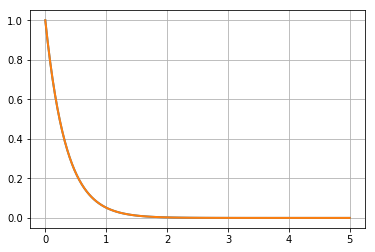

In [19]:
# code for this exercise
def RK3(f, x, y, h):
    # One step with the 3th order Runge-Kutta method
    k1 = f(x,y)
    k2 = f(x + 3*h/4, y + h*k1/2)
    k3 = f(x + 3*h/4, y + 4*h*k2/4)    
    y_next = y + h*(2*k1 + 3*k2 + 4*k3)/9
    x_next = x + h
    return x_next, y_next

#  Differential equation
def f(x, y):
    return array([-41*y[0] + 38*y[1],
                19*y[0] - 22*y[1]])

# Initial values and integration domain
y0 = array([1, 1])
a = 0
b = 5
h = 0.04 

x_num, y_num = ode_solver(f, a, b, y0, h, RK3)
plot(x_num, y_num)

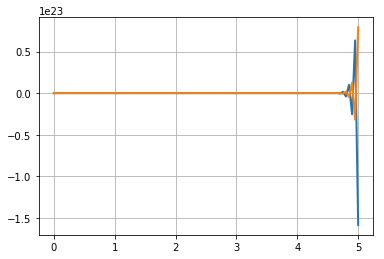

In [20]:
h = 0.05
x_num, y_num = ode_solver(f, a, b, y0, h, RK3)
plot(x_num, y_num)

#### Exercise 4:
##### a)

A numerical ODE method is $A(0)$-stable if the stability interval $\mathcal{S}$ defined by

$$
\mathcal{S} = \{ z \in \mathbb{R} \; :\; |R(z)| \leq 1 \}.
$$

contains all negative numbers, i.e. for all $z < 0$ we have that $|R(z)| \le 0$. 

We first compute the stability function of the implicit midpoint rule. Using $f(x, y) = \lambda y$, we get that 

$$y_{n+1} = y_n + h\lambda (y_n + y_{n+1})/2 = y_n\left(1 + \frac{h\lambda}{2}\right) + \frac{h\lambda}{2}y_{n+1}.$$

Solving for $y_{n+1}$ we
obtain 

$$y_{n+1} = y_n\frac{1 + h\lambda/2}{1 - h\lambda/2}.$$

The stability function in this case is then

\begin{align*}
R(z) &= \frac{y_{n+1}}{y_n} = \frac{1 + h\lambda/2}{1 - h\lambda/2} = \frac{1 + z/2}{1 - z/2}.
\end{align*}

When $z < 0$, we have that $1 + z/2 < 1 - z/2$, which implies that $R(z) \le 1.$ In other words the method is $A(0)$-stable.

##### b)

Using that $f(x,y) = Ay + g(x)$ together with the implicit midpoint rule we obtain

$$y_{n+1} = y_n + h(A[(y_{n+1} + y_n)/2] + g(x_n + h/2)) = (I + hA/2)y_n + hAy_{n+1}/2 + hg(x_n + h/2).$$

Hence we get that 

$$(I-hA/2)y_{n+1}=(I+hA/2)y_n+hg(x_n+h/2),$$

which is the linear equation we need to solve.

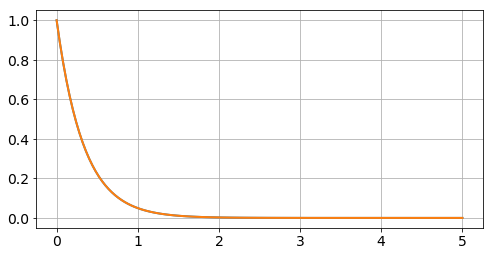

In [24]:
# NB: the function 'solve' must be imported from numpy.linalg
def implicit_midpoint(rhs, x, y, h):
    # One step with the implicit midpoint
    # rule for equations on the form
    # y' = Ay + g(x)
    A, gx = rhs(x + h/2)
    d = len(gx)                      # The dimensions to the system
    M = eye(d) - (h/2)*A             # M = I - (h/2)A
    B = eye(d) + (h/2)*A
    b = np.dot(B,y) + h*gx           # b = (I+A/2)y + hg(x+h/2)
    y_next = solve(M, b)             # Solve M y_next = b
    x_next = x + h
    return x_next, y_next

# Test method on the same problem as before
def rhs(x):
    # Define the right handside of the differential equation
    # Returnerer matrisen A og f(x).
    A = array([[-41, 38],
               [19, -22]])
    gx = array([0, 0])
    return A, gx

# Initial values and integration domain
y0 = array([1, 1])
a, b = 0, 5
h = 0.04

x_num, y_num = ode_solver(rhs, a, b, y0 , h, implicit_midpoint)
plot(x_num, y_num)

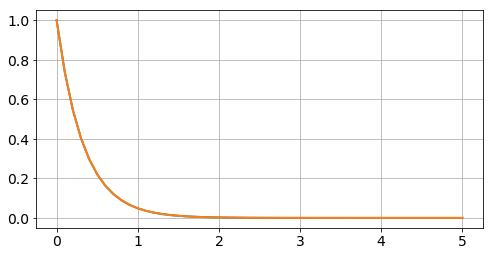

In [25]:
# solve with large time step
h = 0.1

x_num, y_num = ode_solver(rhs, a, b, y0 , h, implicit_midpoint)
plot(x_num, y_num)

We see that the method is stable even for large time steps, unlike the Runge-Kutta method used earlier.

#### Exercise 5:
##### a)

The derivative of the polynomial 

$$p\left( \theta \right) = a\theta^{3} + b\theta^{2} + c\theta + d$$

is 

$$p'\left(\theta\right) = 3a\theta^{2} + 2b\theta + c.$$

Using the conditions $p\left(0\right) = y_{n}$ and $p'\left(0\right) = hy'_{n}$ we can conclude that $d = y_{n}$ and $c = hy'_{n}$. To find the two last constants we use the remaning equations:

$$p\left(1\right) = a + b + hy_{n}' + y_{n} = y_{n+1}$$

and

$$p'\left(1\right) = 3a + 2b + hy'_{n} = hy_{n+1}'.$$

Solving this system of equations we obtain that

\begin{align*}
a &= hy_{n+1}' + hy_{n}' - 2y_{n+1} + 2y_{n}\\
b &= -hy_{n+1}' - 2hy_{n}' + 3y_{n+1} - 3y_{n}.
\end{align*}



##### b)

Using the values

$$ y_n = 6.03, \qquad y_{n+1} = 5.91, \qquad y'_n = 5.41, \qquad y'_{n+1} = -8.29, \qquad h = 0.5,$$

we get the constants 

$$ a = 0.5\cdot (-8.29) + 0.5\cdot5.41 - 2\cdot5.91 + 2\cdot6.03 = -1.2,$$

$$ b = -0.5\cdot(-8.29) - 2\cdot0.5\cdot5.41 + 3\cdot5.91 - 3\cdot 6.03 = -1.625,$$

$$ c = 0.5\cdot5.41 = 2.705\qquad\text{ and } d = 6.03.$$

Hence the polynomial is given by $$p(\theta) = -1.2\theta^3 - 1.625\theta^2 + 2.705\theta + 6.03.$$

If we want to move this polynomial from the interval $[0, 1]$ to the interval $[6.5, 7.0]$ we need to precompose the polynomial with $2x - 13,$ which is the linear transformation taking $6.5 \mapsto 0$ and $7.0 \mapsto 1$. In this case we have that 

$$g(x) = p(2x - 13) = 2332.64 - 1126.89 x + 180.7 x^2 - 9.6 x^3.$$

##### c)

Text(0,0.5,'g(x)')

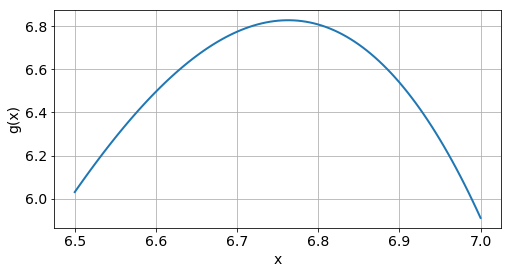

In [26]:
def g(x):
    return 2332.64 - 1126.89* x + 180.7 *x**2 - 9.6* x**3

a = 6.5
b = 7.0
xdata = linspace(a, b, 101)
ydata = g(xdata)

plot(xdata, ydata)
xlabel('x')
ylabel('g(x)')

From the picture we can see that the approximation looks quite good between the points $6$ and $6.5$.